# Lesson 3: Attention Mechanism

Welcome to Lesson 3! Today, we’re diving into the **attention mechanism**, the magic behind transformer models like Llama 2. Attention helps a model focus on the most important parts of a sentence, much like how you pay attention to key words when reading. Since you’re new to LLMs and transformers, we’ll build it step-by-step using PyTorch, with lots of explanations and examples.

## What You’ll Learn
- What attention is and why it’s crucial for language models.
- How to create a single attention head with **query**, **key**, and **value** vectors.
- How to process Chinese text from `data.csv` and visualize attention weights.
- Every step of the attention computation, broken down for beginners.

## Our Data
We’re using `data.csv`, which contains Chinese text in the `head` column. This is real-world data, written in a casual Hong Kong style (e.g., from Lihkg). For example: *法國紅酒慢煮阿根廷牛舌 配 煙肉洋蔥炒著仔*. We’ll use this to see how attention works with Chinese!

## Prerequisites
- PyTorch installed (from Lesson 0).
- `data.csv` ready with columns `user`, `title`, `head`.
- Basic Python knowledge (no prior LLM experience needed!).

## Step 1: Import Libraries

First, let’s bring in the tools we need. Don’t worry if some names sound unfamiliar—we’ll explain them as we go!

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed so our results are consistent
torch.manual_seed(42)

# Check if PyTorch is working
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu118


## Step 2: Load and Explore the Chinese Data

Let’s load `data.csv` and take a look at our Chinese text. We’ll use the `head` column, which has the main content.

In [2]:
# Load the dataset
data_path = 'data/data.csv'
df = pd.read_csv(data_path)

# Show the first few rows
print("First 3 rows of data:")
print(df.head(3))

# Pick a sample from the 'head' column
sample_text = df['head'].iloc[0]
print("\nSample Chinese text we'll work with:")
print(sample_text)

First 3 rows of data:
    user                      title  \
0  慘過番印度  是靚午 法國紅酒慢煮阿根廷牛舌 配 煙肉洋蔥炒著仔   
1  慘過番印度               是靚午 仙台風燒牛舌定食   
2  慘過番印度               衰妹愈大愈有女人味...   

                                                head  
0  法國紅酒慢煮阿根廷牛舌 配 煙肉洋蔥炒著仔#wail#pig\n（$60-5）#wail#p...  
1  仙台風燒牛舌定食#wail#pig\n（$63）#wail#pig\n\n講吓味道先#wai...  
2                                         是#wail#pig  

Sample Chinese text we'll work with:
法國紅酒慢煮阿根廷牛舌 配 煙肉洋蔥炒著仔#wail#pig\n（$60-5）#wail#pig\n\n講吓味道先#wail#pig\n牛舌有成5大塊#wail#pig\n已經煮到好淋#wail#pig\n入口很香，幾乎即化#wail#pig\n配埋個酸酸地嘅紅酒汁解膩一流#wail#pig\n同炒著仔都很夾#wail#pig\n有脷有著有菜#wail#pig\n又是健康嘅一餐#wail#pig\n食完條脷根好C伏#wail#pig


## Step 3: Simulate Tokenization and Embeddings

### What’s Happening Here?
Before attention, we need to turn our Chinese text into numbers a model can understand. This involves:
1. **Tokenization**: Splitting text into small pieces (e.g., characters or words). For Chinese, we might split into characters like `法`, `國`, `紅`, or into meaningful chunks like `法國` (France) or `紅酒` (red wine).
2. **Embeddings**: Turning each token into a vector of numbers (e.g., `[0.1, -0.5, 0.3, ...]`), which captures its meaning in a way the model can process.

In Lesson 2, we covered this, but for now, we’ll *simulate* it with random numbers to focus on attention. Imagine we’ve tokenized our sample text into 6 pieces (e.g., `法國`, `紅酒`, `慢煮`, `阿根廷`, `牛舌`, `配`) and turned them into embeddings.

**Note**: Tokens aren’t always single characters; they can be multiple characters, like `阿根廷` (Argentina) as one token. This depends on the tokenizer’s rules or training data.

### Full Flow Recap Example

These examples are *not* the actual embeddings; they’re just to help you understand how text transforms into numbers for the model:

- **Characters**: 法國紅酒慢煮阿根廷牛舌 → [法, 國, 紅, 酒, 慢, 煮, 阿, 根, 廷, 牛, 舌]
- **Tokens**: [法國, 紅酒, 慢煮, 阿根廷, 牛舌] (e.g., via a subword tokenizer)
- **Embeddings**:
```
[
  [0.1, -0.2, 0.5, 0.3, ...],   # 法國 (France)
  [0.4, 0.1, -0.3, 0.7, ...],   # 紅酒 (red wine)
  [-0.1, 0.6, 0.0, -0.4, ...],  # 慢煮 (slow-cooked)
  [0.2, -0.5, 0.8, 0.1, ...],   # 阿根廷 (Argentina)
  [0.3, 0.2, -0.1, 0.9, ...]    # 牛舌 (beef tongue)
]
```

### Let’s Do It
We’ll create a small batch of embeddings to represent 6 tokens.

In [3]:
# Define sizes
batch_size = 1    # One sentence at a time
seq_length = 6    # 6 tokens (e.g., 法國, 紅酒, 慢煮, 阿根廷, 牛舌, 配)
embed_dim = 64    # Each token gets a vector of 64 numbers

# Create fake embeddings (random numbers)
X = torch.randn(batch_size, seq_length, embed_dim)
print("Input shape:", X.shape)  # Should be [1, 6, 64]
print("First token’s embedding (partial):", X[0, 0, :5])  # Peek at first 5 numbers

Input shape: torch.Size([1, 6, 64])
First token’s embedding (partial): tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784])


## Step 4: Understand Attention Basics

### Why Attention?
Imagine reading: *法國紅酒慢煮阿根廷牛舌 配 煙肉洋蔥炒著仔*. To understand `牛舌` (beef tongue), you’d naturally focus on words like `慢煮` (slow-cooked) and `紅酒` (red wine), which describe its preparation, rather than `洋蔥` (onion), which relates to a side dish. Attention lets the model do this automatically, figuring out which parts of the sentence matter most for each word!

This ability to focus dynamically is why transformers excel at tasks like translation or text generation, where context from different parts of the input is crucial.

### How It Works
Attention uses three key components:
- **Query (Q)**: What a token is *looking for*. For example, `牛舌` might ask, “Which words tell me how I’m prepared?”
- **Key (K)**: What each token *offers*. All tokens (e.g., `紅酒`, `慢煮`) provide clues about their relevance.
- **Value (V)**: The actual information shared once relevance is determined. If `慢煮` is relevant to `牛舌`, its value contributes to `牛舌`’s new representation.

Here’s the process in detail:
1. Each token in the input sequence (like `法國`, `紅酒`) is transformed into three vectors: **query**, **key**, and **value** using linear transformations.
2. The **query vector** of one token (e.g., `牛舌`) is compared to the **key vectors** of all tokens to measure similarity (how much they relate).
3. These similarities become **attention scores**, which are scaled and normalized into **attention weights** (probabilities).
4. The **value vectors** are then combined based on these weights, creating a new representation for each token that reflects the context it cares about.

For example, `牛舌` might end up with a representation heavily influenced by `慢煮` and `紅酒`, but not `洋蔥`.

### The Formula
We’ll compute:
\[ \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V \]

Don’t worry—this looks scary, but it’s simple when broken down:
- **QK^T**: The dot product between query (Q) and key (K) vectors, giving raw similarity scores.
- **Scaling (÷ √d_k)**: Divides the scores by the square root of the key vector dimension (`d_k`) to prevent them from getting too large, which helps training stability.
- **Softmax**: Turns scores into probabilities (weights) that sum to 1, showing how much focus each token gets.
- **Multiply by V**: Uses these weights to blend the value vectors, producing the final output.

This process lets the model dynamically adjust its focus for each token, making it powerful for understanding language context.

```text
[Input: 法國紅酒慢煮阿根廷牛舌配]  (Embeddings [1, 6, 64])
       |
       |-------------------|-------------------|
       |                   |                   |
[Query: Q]          [Key: K]           [Value: V]
(法國 Q, 牛舌 Q, ...)  (慢煮 K, 配 K, ...)  (紅酒 V, 阿根廷 V, ...)
[1, 6, 32]          [1, 6, 32]          [1, 6, 32]
       |                   |
       |-------------------|
              |
       [Scores: QK^T]  (e.g., 牛舌 vs 慢煮 = 2.5)
       [1, 6, 6]   ---> [Scale: ÷ √32]
              |
       [Weights: Softmax]  (e.g., 牛舌 -> 慢煮 = 0.45)
       [1, 6, 6]
              |
       [Output: Weights × V]  (e.g., 牛舌 mixes 慢煮 V, 紅酒 V)
       [1, 6, 32]
              |
[Final Output: Context-Aware Tokens]
(法國', 紅酒', 慢煮', 阿根廷', 牛舌', 配')
[1, 6, 32]
```

In [4]:
import base64
from IPython.display import Image, display

def mm_ink(graphbytes):
  """Given a bytes object holding a Mermaid-format graph, return a URL that will generate the image."""
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  return "https://mermaid.ink/img/" + base64_string

def mm_display(graphbytes):
  """Given a bytes object holding a Mermaid-format graph, display it."""
  display(Image(url=mm_ink(graphbytes)))

def mm(graph):
  """Given a string containing a Mermaid-format graph, display it."""
  graphbytes = graph.encode("utf-8")
  mm_display(graphbytes)


mm("""
flowchart TD
    subgraph Input["Step 1: Input Tokens with Embeddings"]
        T1["法國 [0.1, -0.2]"]
        T2["紅酒 [0.4, 0.1]"]
        T3["牛舌 [0.3, 0.2]"]
    end

    subgraph Transform["Linear Transformation"]
        direction TB
        Q["Queries (Q)"]
        K["Keys (K)"]
        V["Values (V)"]
    end

    subgraph QKV["Token Vectors"]
        direction TB
        Q1["法國 Q: [0.2, 0.1]"]
        Q2["紅酒 Q: [0.3, -0.1]"]
        Q3["牛舌 Q: [0.1, 0.4]"]
        K1["法國 K: [0.1, 0.3]"]
        K2["紅酒 K: [0.2, -0.2]"]
        K3["牛舌 K: [0.5, 0.0]"]
        V1["法國 V: [0.4, 0.2]"]
        V2["紅酒 V: [0.3, -0.1]"]
        V3["牛舌 V: [0.2, 0.5]"]
    end

    subgraph Compare["Step 2: Query-Key Comparison"]
        direction TB
        C1["牛舌·法國 = 0.13"]
        C2["牛舌·紅酒 = -0.06"]
        C3["牛舌·牛舌 = 0.05"]
    end

    subgraph Normalize["Step 3: Scale and Softmax"]
        direction TB
        N1["Scale: [0.065, -0.03, 0.025]"]
        N2["Weights: [0.38, 0.30, 0.32]"]
    end

    subgraph Combine["Step 4: Weighted Values"]
        direction TB
        W1["法國: [0.152, 0.076]"]
        W2["紅酒: [0.09, -0.03]"]
        W3["牛舌: [0.064, 0.16]"]
        Sum["Final: [0.306, 0.206]"]
    end

    subgraph Output["Context-Aware Representations"]
        O1["法國': [x, y]"]
        O2["紅酒': [a, b]"]
        O3["牛舌': [0.306, 0.206]"]
    end

    Input --> Transform
    Transform --> QKV
    QKV --> Compare
    Compare --> Normalize
    Normalize --> Combine
    Combine --> Output

    style Input fill:#f0f0f0
    style Transform fill:#e1f5fe
    style QKV fill:#e8f5e9
    style Compare fill:#fff3e0
    style Normalize fill:#fce4ec
    style Combine fill:#f3e5f5
    style Output fill:#e8eaf6
""")


## Step 5: Build the Attention Head Step-by-Step

Let’s create a single attention head. We’ll define a class and go through each part slowly.

In [5]:
# Define the attention head class
class SingleHeadAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        # Linear layers to create Q, K, V from embeddings
        self.query = nn.Linear(embed_dim, head_dim)  # For queries
        self.key = nn.Linear(embed_dim, head_dim)    # For keys
        self.value = nn.Linear(embed_dim, head_dim)  # For values
        self.scale = head_dim ** -0.5  # Scaling factor to keep numbers stable

    def forward(self, x):
        # Input x is our embeddings: [batch_size, seq_length, embed_dim]
        return x  # We’ll fill this in step-by-step

# Set dimensions
head_dim = 32  # Smaller size for Q, K, V vectors
attention = SingleHeadAttention(embed_dim, head_dim)

### Step 5.1: Compute Query, Key, Value

Our input `X` has shape `[1, 6, 64]` (1 batch, 6 tokens, 64 embedding size). We’ll transform it into Q, K, V with shape `[1, 6, 32]` using linear layers.

- **Query**: What each token wants to ask (e.g., `牛舌` asks about preparation).
- **Key**: What each token offers (e.g., `慢煮` offers cooking info).
- **Value**: What each token provides if chosen (e.g., `慢煮`’s meaning).

In [6]:
# Test computing Q, K, V
Q = attention.query(X)  # [1, 6, 32]
K = attention.key(X)    # [1, 6, 32]
V = attention.value(X)  # [1, 6, 32]

print("Query shape:", Q.shape)
print("Key shape:", K.shape)
print("Value shape:", V.shape)
print("First token’s Query (partial):", Q[0, 0, :5])

Query shape: torch.Size([1, 6, 32])
Key shape: torch.Size([1, 6, 32])
Value shape: torch.Size([1, 6, 32])
First token’s Query (partial): tensor([-0.0636,  0.1999,  0.3005, -0.2582,  0.4138], grad_fn=<SliceBackward0>)


### Step 5.2: Calculate Attention Scores

Now, we compare every query to every key using a dot product. For each of our 6 tokens, we’ll get a score against all 6 tokens, creating a `[6, 6]` score matrix.

- **Dot Product**: Measures similarity (higher = more similar). For example, `牛舌`’s query dot product with `慢煮`’s key might be high.
- **Scaling**: Divide by √(head_dim) (here, √32 ≈ 5.66) to keep scores manageable and improve training.

In math: \( \text{scores} = \frac{QK^T}{\sqrt{d_k}} \)

In [7]:
# Compute scores
scores = torch.matmul(Q, K.transpose(-2, -1))  # [1, 6, 6]
scores = scores * attention.scale  # Scale it

print("Scores shape:", scores.shape)
print("Scores for first token (partial):", scores[0, 0, :3])

Scores shape: torch.Size([1, 6, 6])
Scores for first token (partial): tensor([ 0.6851, -0.2949, -0.0752], grad_fn=<SliceBackward0>)


### Step 5.3: Apply Softmax to Get Weights

Raw scores are hard to interpret, so we use **softmax** to turn them into probabilities (numbers between 0 and 1 that sum to 1). This tells us *how much* each token should focus on every other token.

For example, `牛舌` might give a high weight (e.g., 0.5) to `慢煮` and a low weight (e.g., 0.05) to `洋蔥`. The softmax ensures these weights add up to 1 for each query token.

In [8]:
# Apply softmax
attn_weights = torch.softmax(scores, dim=-1)  # [1, 6, 6]

print("Attention weights shape:", attn_weights.shape)
print("Weights for first token:", attn_weights[0, 0])
print("Sum of weights (should be ~1):", attn_weights[0, 0].sum())

Attention weights shape: torch.Size([1, 6, 6])
Weights for first token: tensor([0.2838, 0.1065, 0.1327, 0.1016, 0.1399, 0.2356],
       grad_fn=<SelectBackward0>)
Sum of weights (should be ~1): tensor(1.0000, grad_fn=<SumBackward0>)


### Step 5.4: Combine with Values

Now, use these weights to pick out the important parts of `V`. Multiply the weights `[1, 6, 6]` by `V` `[1, 6, 32]` to get an output `[1, 6, 32]`. Each token’s new representation is a weighted mix of all value vectors, based on attention.

In math: \( \text{output} = \text{softmax}(\text{scores}) \cdot V \)

This creates a context-aware version of each token. For `牛舌`, its output might mostly reflect `慢煮` and `紅酒`.

In [9]:
# Compute output
output = torch.matmul(attn_weights, V)  # [1, 6, 32]

print("Output shape:", output.shape)
print("First token’s output (partial):", output[0, 0, :5])

Output shape: torch.Size([1, 6, 32])
First token’s output (partial): tensor([ 0.3050,  0.3526,  0.3727, -0.2835,  0.0748], grad_fn=<SliceBackward0>)


### Step 5.5: Put It All Together

Let’s update our class with the full forward pass. We’ll return both the output and attention weights so we can visualize them later.

In [10]:
class SingleHeadAttention(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, head_dim)
        self.key = nn.Linear(embed_dim, head_dim)
        self.value = nn.Linear(embed_dim, head_dim)
        self.scale = head_dim ** -0.5

    def forward(self, x):
        Q = self.query(x)                     # [batch_size, seq_length, head_dim]
        K = self.key(x)                       # [batch_size, seq_length, head_dim]
        V = self.value(x)                     # [batch_size, seq_length, head_dim]
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [batch_size, seq_length, seq_length]
        attn_weights = torch.softmax(scores, dim=-1)  # [batch_size, seq_length, seq_length]
        out = torch.matmul(attn_weights, V)   # [batch_size, seq_length, head_dim]
        return out, attn_weights

# Test it
attention = SingleHeadAttention(embed_dim, head_dim)
output, attn_weights = attention(X)
print("Final output shape:", output.shape)
print("Final attn_weights shape:", attn_weights.shape)

Final output shape: torch.Size([1, 6, 32])
Final attn_weights shape: torch.Size([1, 6, 6])


## Step 6: Visualize Attention Weights

Let’s see how our 6 tokens (e.g., `法國`, `紅酒`, `慢煮`, `阿根廷`, `牛舌`, `配`) pay attention to each other using a heatmap. To display Chinese characters correctly, we’ll set Matplotlib to use a font that supports Chinese, like `SimHei`.

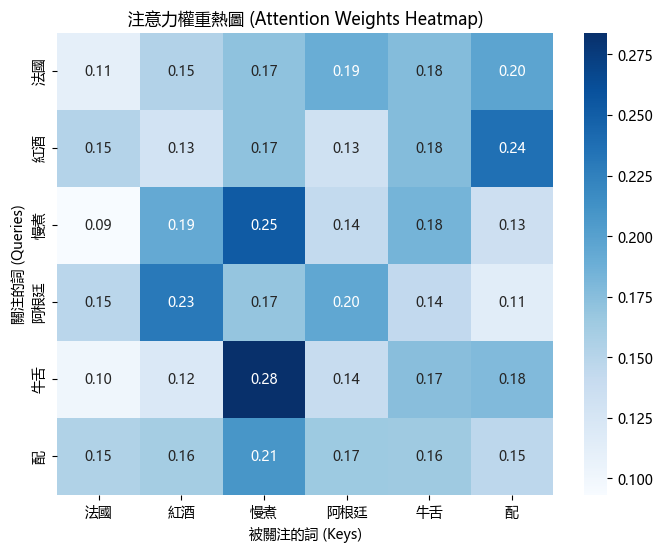

In [18]:
# Set up font for Chinese characters
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Or another font that supports Chinese
plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

# Convert weights to numpy for plotting
attn_weights_np = attn_weights[0].detach().numpy()

# Fake token labels (since we simulated data)
tokens = ['法國', '紅酒', '慢煮', '阿根廷', '牛舌', '配']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(attn_weights_np, annot=True, cmap='Blues', fmt='.2f', xticklabels=tokens, yticklabels=tokens)
plt.title('注意力權重熱圖 (Attention Weights Heatmap)')
plt.xlabel('被關注的詞 (Keys)')
plt.ylabel('關注的詞 (Queries)')
plt.show()

### What Does This Show?
- **Rows**: Each row represents a token (query) looking at all tokens (keys). For example, the row for `牛舌` shows how much it attends to every other token.
- **Columns**: Each column shows how much a token (key) is attended to by all queries.
- **Values**: High values (darker blue) mean strong attention. If `牛舌` has a high weight on `慢煮` (e.g., 0.5), it means `慢煮` is important for understanding `牛舌`.

**Interpretation Example**: In our sentence, you might see `牛舌` paying strong attention to `慢煮` and `紅酒`, since they describe how the beef tongue is cooked. Meanwhile, it might pay less attention to `配` or `洋蔥`, which relate to the side dish. This shows how attention captures contextual relationships!

## Step 7: Exercises for Practice

Try these to deepen your understanding:
1. **Change `head_dim`**: Set it to 16 or 64. Run the code and check the output shape. What do you notice about the shape of the attention weights?
2. **Longer Sequence**: Change `seq_length` to 8 (add fake tokens like `煙肉`, `洋蔥`). Re-run and visualize. How does the attention pattern change with more tokens?
3. **Peek at Scores**: Add `print(scores[0])` before softmax in the `forward` method. What do the raw scores look like? Are there any patterns or large values?
4. **Interpret Attention**: Look at the heatmap. Which token pays the most attention to `牛舌`? Does it make sense based on the sentence meaning (e.g., preparation vs. side dish)?

Write your code below and experiment!

In [12]:
# Your exercise code here



## Summary

Wow, you did it! Here’s what we covered:
- **Attention’s Purpose**: It helps the model focus on important tokens, like how `牛舌` relates to `慢煮` and `紅酒`.
- **Building It**: We created a single attention head with Q, K, V, step-by-step.
- **Visualization**: We plotted attention weights to see relationships in our Chinese text.

Next time, in Lesson 4, we’ll add more heads (multi-head attention) and build a full transformer block. You’re on your way to mastering LLMs!